<a href="https://colab.research.google.com/github/4LanCrane/Data-Mining-CI603/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import array, col,size,lit,array_except,explode,avg,array_contains,lower,expr
from pyspark.ml.fpm import FPGrowth
import matplotlib.pyplot as plt
import kagglehub
file_path = kagglehub.dataset_download("choongqianzheng/disease-and-symptoms-dataset")

In [46]:
# function for creating a spark session
def create_spark_session(app_name="HealthData"):
    return SparkSession.builder.appName(app_name).getOrCreate()

# function for creating a dataframe
def create_Dataframe(spark,file_path):
    return spark.read.csv(file_path, header=True, inferSchema=True)

# extracts symptoms colums from dataframe, resource used for code https://www.kaggle.com/code/megan3/market-basket-analysis-using-pyspark
def extract_symptoms_column(df):
    symptom_columns = [col_name for col_name in df.columns if col_name != 'Disease']
    df = df.withColumn('Symptoms', array(*symptom_columns))
    return df.select('Disease', 'Symptoms')

# runs fpGrowth and returns model
def run_fp_growth(df_aggregated,items_col_value, minSupport, minConfidence):
    fp = FPGrowth(itemsCol=items_col_value, minSupport=minSupport, minConfidence=minConfidence)
    model = fp.fit(df_aggregated)
    return model

# prints the number of distinct values
def countDistinct(df, columnName,colTitle):
  print("Number of unique " + colTitle + "=",df.select(columnName).distinct().count())


# splits each symptom into a new row
def explode_symptoms_column(df, symptoms_col="Symptoms"):
    exploded_df = df.select(explode(col(symptoms_col)).alias("Symptom"))
    return exploded_df

# removes all nuls from the symptoms array and removes whitespace, resource used for code https://www.kaggle.com/code/megan3/market-basket-analysis-using-pyspark
def remove_null_symptoms_and_trim(df, symptoms_col="Symptoms"):
    cleaned_df = df.select(
        "Disease",
        array_except(col(symptoms_col), array(lit(None))).alias(symptoms_col)
    )

    cleaned_df = cleaned_df.withColumn(
        symptoms_col,
        expr(f"transform({symptoms_col}, x -> trim(x))")
    )
    return cleaned_df

# calulates the representation of each symptom within the dataset as a percentage
def calculate_symptom_percentages(exploded_df):
    total_symptoms = exploded_df.count()

    symptom_counts = exploded_df.groupBy("Symptom").count()

    symptom_counts = symptom_counts.withColumn(
        "percentage", (col("count") / total_symptoms) * 100
    )

    return symptom_counts

# Creates a barchart to show the percentage of each symptom
def plot_symptom_percentages(df_pd, top_n=None):
    if top_n:
        df_pd = df_pd.head(top_n)

    plt.figure(figsize=(14, 8))
    plt.bar(df_pd["Symptom"], df_pd["percentage"], color='skyblue')
    plt.xticks(rotation=90)
    plt.xlabel("Symptom")
    plt.ylabel("Percentage (%)")
    plt.title("Percentage of Each Symptom in Dataset")
    plt.tight_layout()
    plt.show()

#calulates the average symptoms within the dataset
def calculate_average_symptoms(df, symptoms_col="Symptoms"):
    df_with_countsForEach = df.withColumn("num_symptoms", size(col(symptoms_col)))
    avg_symptoms = df_with_countsForEach.select(avg("num_symptoms")).first()[0]
    return avg_symptoms

Create Spark Session

In [47]:
spark = create_spark_session()
df = create_Dataframe(spark, file_path)

Print number of records

In [48]:
numOfRecords = df.count()
print("Number of records = ", numOfRecords)

Number of records =  4961


Combine multiple symptom colums into one Symptoms array

In [49]:
df = extract_symptoms_column(df)

In [50]:
df.show(10,False)

+----------------+------------------------------------------------------------------------------------------------------------------------------------------------+
|Disease         |Symptoms                                                                                                                                        |
+----------------+------------------------------------------------------------------------------------------------------------------------------------------------+
|Fungal infection|[itching,  skin_rash,  nodal_skin_eruptions,  dischromic _patches, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL]|
|Fungal infection|[ skin_rash,  nodal_skin_eruptions,  dischromic _patches, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL]   |
|Fungal infection|[itching,  nodal_skin_eruptions,  dischromic _patches, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL]      |
|Fungal infectio

Seprate each Symptom into a new row and display count of each

In [51]:
exploded_df = explode_symptoms_column(df)
exploded_df.groupBy("Symptom").count().orderBy("count", ascending=False).show(10)

+------------------+-----+
|           Symptom|count|
+------------------+-----+
|              NULL|47527|
|           fatigue| 1932|
|          vomiting| 1914|
|        high_fever| 1362|
|  loss_of_appetite| 1152|
|            nausea| 1146|
|          headache| 1134|
|    abdominal_pain| 1032|
|    yellowish_skin|  912|
| yellowing_of_eyes|  816|
+------------------+-----+
only showing top 10 rows



Calulate the percentage each Symptom represents in the dataset

In [52]:
symptoms_percent_withNull = calculate_symptom_percentages(exploded_df).orderBy("percentage", ascending=False)
symptoms_percent_withNull.show(10)

+------------------+-----+------------------+
|           Symptom|count|        percentage|
+------------------+-----+------------------+
|              NULL|47527| 56.35367632237334|
|           fatigue| 1932|2.2908094904964607|
|          vomiting| 1914| 2.269466544932829|
|        high_fever| 1362|1.6149495476481261|
|  loss_of_appetite| 1152|1.3659485160724236|
|            nausea| 1146|1.3588342008845467|
|          headache| 1134| 1.344605570508792|
|    abdominal_pain| 1032|1.2236622123148795|
|    yellowish_skin|  912|1.0813759085573356|
| yellowing_of_eyes|  816|0.9675468655513001|
+------------------+-----+------------------+
only showing top 10 rows



Plot the percentage of each symptom within the dataset to a bar chart (Including null values)

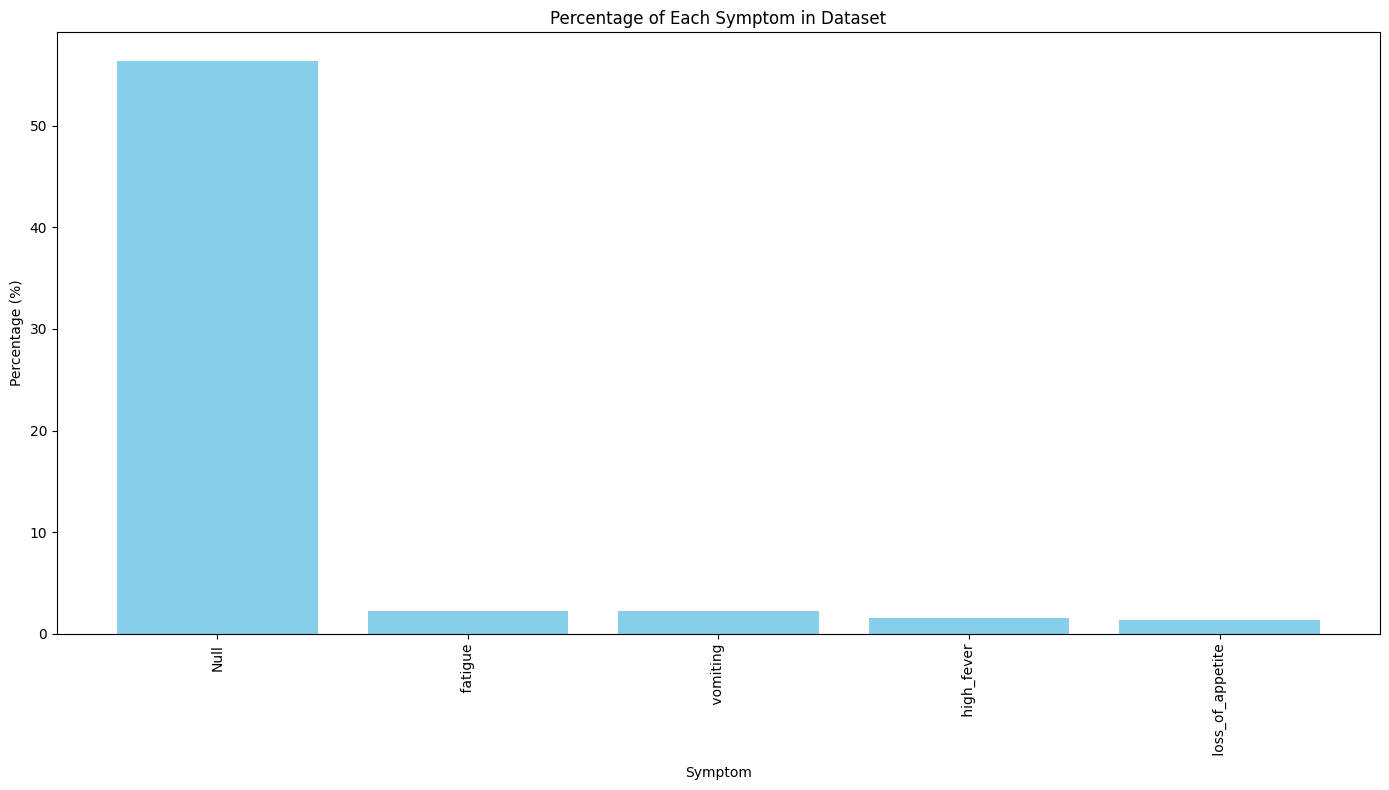

In [53]:
symptoms_percent_withNull_pd = symptoms_percent_withNull.toPandas()
symptoms_percent_withNull_pd['Symptom'] = symptoms_percent_withNull_pd['Symptom'].fillna('Null')
plot_symptom_percentages(symptoms_percent_withNull_pd, top_n=5)

Remove all null values from Symptoms and remove whitespace


In [54]:
df_aggregated = remove_null_symptoms_and_trim(df)
df_aggregated.show(3,False)

+----------------+---------------------------------------------------------------+
|Disease         |Symptoms                                                       |
+----------------+---------------------------------------------------------------+
|Fungal infection|[itching, skin_rash, nodal_skin_eruptions, dischromic _patches]|
|Fungal infection|[skin_rash, nodal_skin_eruptions, dischromic _patches]         |
|Fungal infection|[itching, nodal_skin_eruptions, dischromic _patches]           |
+----------------+---------------------------------------------------------------+
only showing top 3 rows



Calulate the average number of symptoms per disease

In [55]:
print("Average number of symptoms per disease:", calculate_average_symptoms(df_aggregated))

Average number of symptoms per disease: 7.419875025196533


Display number of "Distinct" diseases and symptoms

In [56]:
countDistinct(df_aggregated,"Disease","diseases")
countDistinct(df_aggregated,"Symptoms","symptoms")

Number of unique diseases= 41
Number of unique symptoms= 345


Calulate percentages without Null values for use with Pandas.





In [57]:
symptoms_percent_withoutNull = calculate_symptom_percentages(explode_symptoms_column(df_aggregated)).orderBy("percentage", ascending=False)
symptoms_percent_withoutNull.show(10)

+-----------------+-----+------------------+
|          Symptom|count|        percentage|
+-----------------+-----+------------------+
|          fatigue| 1932| 5.248573757131214|
|         vomiting| 1914| 5.199674001629992|
|       high_fever| 1362|3.7000814995925024|
| loss_of_appetite| 1152|3.1295843520782394|
|           nausea| 1146| 3.113284433577832|
|         headache| 1134|3.0806845965770173|
|   abdominal_pain| 1032|2.8035859820700897|
|   yellowish_skin|  912|2.4775876120619396|
|yellowing_of_eyes|  816|2.2167889160554197|
|           chills|  798|2.1678891605541972|
+-----------------+-----+------------------+
only showing top 10 rows



Plot symptom percentages within dataset (without null values)

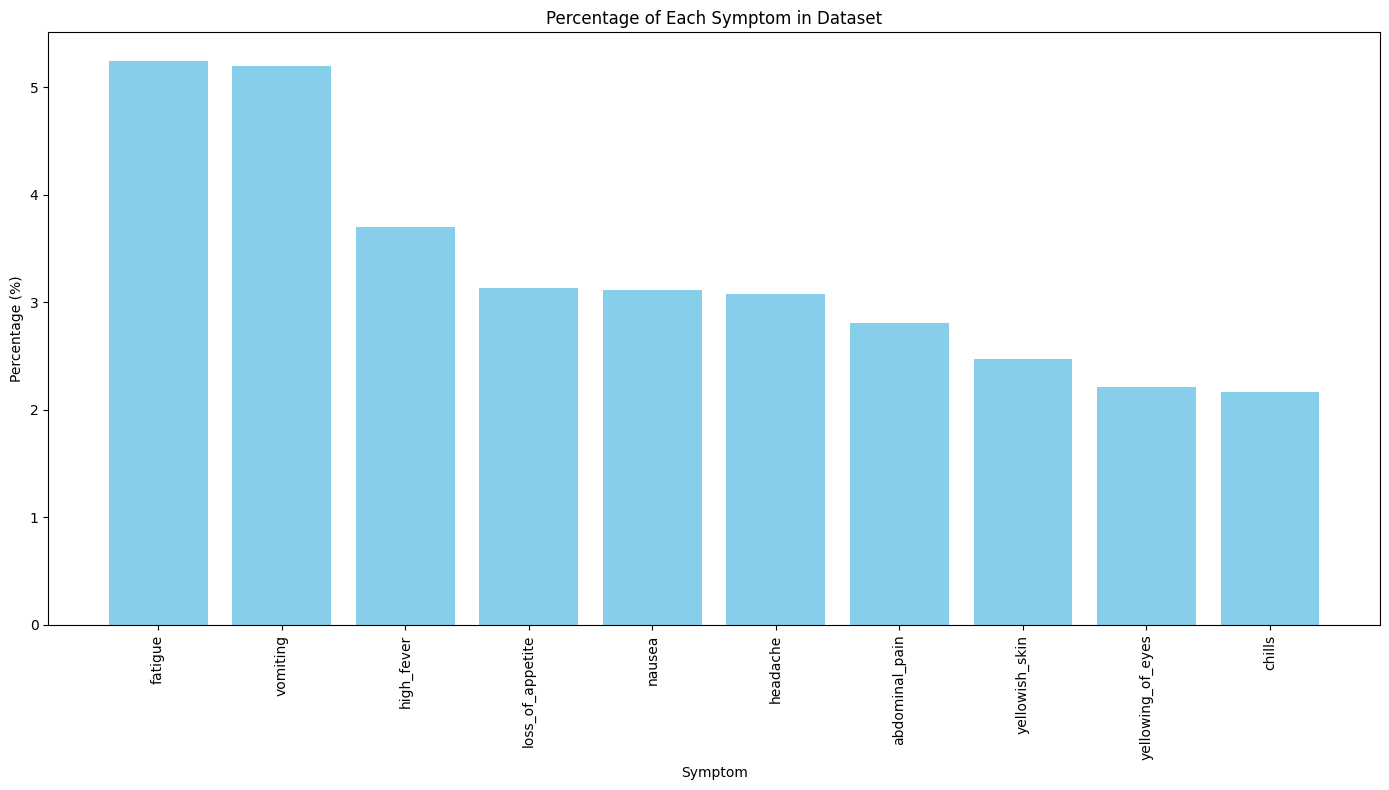

In [58]:
plot_symptom_percentages(symptoms_percent_withoutNull.toPandas(), top_n=10)

Low confidence and support implemention of FP_Growth passing the "Symptoms" two-dimensional Array (minSupport = 0.06, minConfidence = 0.1)

In [59]:
model = run_fp_growth(df_aggregated, "Symptoms", 0.06, 0.1)
model.associationRules.show(30, False)

+-----------------------------------------------------------------------+-------------------+------------------+------------------+--------------------+
|antecedent                                                             |consequent         |confidence        |lift              |support             |
+-----------------------------------------------------------------------+-------------------+------------------+------------------+--------------------+
|[dark_urine]                                                           |[yellowing_of_eyes]|0.7894736842105263|4.799729102167183 |0.09070751864543439 |
|[dark_urine]                                                           |[joint_pain]       |0.5684210526315789|4.122714681440444 |0.06530941342471276 |
|[dark_urine]                                                           |[nausea]           |0.5684210526315789|2.4606778726922016|0.06530941342471276 |
|[dark_urine]                                                           |[yellowis

Print the number of association rules

In [60]:
print("Number of association rules:", model.associationRules.count())

Number of association rules: 1191


Show the association Rules ordered by confidence (high to low)

In [61]:
model.associationRules.orderBy("confidence", ascending=False).show(40, False)

+--------------------------------------------------------------+-------------------+------------------+------------------+--------------------+
|antecedent                                                    |consequent         |confidence        |lift              |support             |
+--------------------------------------------------------------+-------------------+------------------+------------------+--------------------+
|[phlegm, cough, malaise, high_fever]                          |[chest_pain]       |1.0               |7.127873563218391 |0.06168111267889538 |
|[phlegm, fatigue]                                             |[chest_pain]       |1.0               |7.127873563218391 |0.06772828058859101 |
|[phlegm, malaise, chills]                                     |[chest_pain]       |1.0               |7.127873563218391 |0.06530941342471276 |
|[phlegm, malaise]                                             |[chest_pain]       |1.0               |7.127873563218391 |0.068937714170

Show the association Rules ordered by confidence (low to high)

In [62]:
model.associationRules.orderBy("confidence", ascending=True).show(40, False)

+------------------+---------------------+-------------------+------------------+-------------------+
|antecedent        |consequent           |confidence         |lift              |support            |
+------------------+---------------------+-------------------+------------------+-------------------+
|[fatigue]         |[breathlessness]     |0.16459627329192547|1.8145824706694273|0.06409997984277363|
|[vomiting]        |[chest_pain]         |0.16614420062695925|1.1842548553309553|0.06409997984277363|
|[fatigue]         |[joint_pain]         |0.16770186335403728|1.216328865642367 |0.06530941342471276|
|[fatigue]         |[itching]            |0.16770186335403728|1.2270928379046888|0.06530941342471276|
|[fatigue]         |[swelled_lymph_nodes]|0.17080745341614906|2.4349878632112514|0.06651884700665188|
|[fatigue]         |[excessive_hunger]   |0.17080745341614906|1.8341467021591245|0.06651884700665188|
|[fatigue]         |[phlegm]             |0.17391304347826086|2.4372390076148363|0

Run FP growth with higher increase min confidence (minSupport = 0.06, minConfidence = 0.5)

In [63]:
model = run_fp_growth(df_aggregated, "Symptoms", 0.06, 0.5)
model.associationRules.show(40, False)

+-----------------------------------------------------------------------+-------------------+------------------+------------------+--------------------+
|antecedent                                                             |consequent         |confidence        |lift              |support             |
+-----------------------------------------------------------------------+-------------------+------------------+------------------+--------------------+
|[dark_urine]                                                           |[yellowing_of_eyes]|0.7894736842105263|4.799729102167183 |0.09070751864543439 |
|[dark_urine]                                                           |[joint_pain]       |0.5684210526315789|4.122714681440444 |0.06530941342471276 |
|[dark_urine]                                                           |[nausea]           |0.5684210526315789|2.4606778726922016|0.06530941342471276 |
|[dark_urine]                                                           |[yellowis

Print the number of association rules

In [64]:
print("Number of association rules:", model.associationRules.count())

Number of association rules: 1012


Show the association Rules ordered by confidence (low to high)

In [65]:
model.associationRules.orderBy("confidence", ascending=True).show(40, False)

+-------------------------------------+-------------------+------------------+------------------+-------------------+
|antecedent                           |consequent         |confidence        |lift              |support            |
+-------------------------------------+-------------------+------------------+------------------+-------------------+
|[chest_pain]                         |[malaise]          |0.5               |3.5334757834757835|0.07014714775246926|
|[fatigue]                            |[high_fever]       |0.5062111801242236|1.8438426318621683|0.19713767385607742|
|[chest_pain]                         |[phlegm]           |0.5086206896551724|7.127873563218389 |0.07135658133440839|
|[vomiting]                           |[nausea]           |0.5109717868338558|2.211981705482337 |0.19713767385607742|
|[nausea, vomiting]                   |[abdominal_pain]   |0.5276073619631901|2.5362985685071573|0.10401128804676477|
|[abdominal_pain]                     |[dark_urine]     

Run FP growth with increased min support (minSupport = 0.08, minConfidence = 0.5)

In [66]:
model = run_fp_growth(df_aggregated, "Symptoms", 0.08, 0.5)
model.associationRules.show(40, False)

+-----------------------------------------------------+-------------------+------------------+------------------+-------------------+
|antecedent                                           |consequent         |confidence        |lift              |support            |
+-----------------------------------------------------+-------------------+------------------+------------------+-------------------+
|[dark_urine, loss_of_appetite]                       |[yellowing_of_eyes]|0.9863013698630136|5.996373892022563 |0.087079217899617  |
|[dark_urine, loss_of_appetite]                       |[yellowish_skin]   |0.9452054794520548|5.141627613554434 |0.08345091715379964|
|[dark_urine, loss_of_appetite]                       |[abdominal_pain]   |0.958904109589041 |4.609615588828714 |0.08466035073573876|
|[loss_of_appetite, vomiting]                         |[yellowing_of_eyes]|0.703125          |4.274758731617648 |0.10884902237452126|
|[loss_of_appetite, vomiting]                         |[nausea

Print the number of association rules

In [67]:
print("Number of association rules:", model.associationRules.count())

Number of association rules: 263


Show the association Rules ordered by support (low to high)

In [68]:
model.associationRules.orderBy("support", ascending=True).show(40, False)

+-----------------------------------------------------+-------------------+------------------+------------------+-------------------+
|antecedent                                           |consequent         |confidence        |lift              |support            |
+-----------------------------------------------------+-------------------+------------------+------------------+-------------------+
|[yellowing_of_eyes, yellowish_skin, loss_of_appetite]|[vomiting]         |0.638095238095238 |1.6539135194307608|0.08103204998992139|
|[yellowing_of_eyes, yellowish_skin, vomiting]        |[abdominal_pain]   |0.9571428571428572|4.601148947951273 |0.08103204998992139|
|[abdominal_pain, nausea, vomiting]                   |[yellowing_of_eyes]|0.7790697674418605|4.736476858185135 |0.08103204998992139|
|[joint_pain, nausea, vomiting]                       |[loss_of_appetite] |0.9710144927536232|4.181599738325282 |0.08103204998992139|
|[yellowing_of_eyes, loss_of_appetite, vomiting]      |[nausea

increase the minsupport and minconfidence (MinSupport = 0.1, MinConfidence = 0.8)

In [69]:
model = run_fp_growth(df_aggregated, "Symptoms", 0.1, 0.8)

Print the number of associationRules now confidence and support increased

In [70]:
print("Number of association rules:", model.associationRules.count())

Number of association rules: 36


Show the association Rules ordered by support (high to low)

In [71]:
model.associationRules.orderBy("support", ascending=False).show(200, False)

+-----------------------------------------------------+-------------------+------------------+------------------+-------------------+
|antecedent                                           |consequent         |confidence        |lift              |support            |
+-----------------------------------------------------+-------------------+------------------+------------------+-------------------+
|[nausea]                                             |[vomiting]         |0.8534031413612565|2.211981705482337 |0.19713767385607742|
|[abdominal_pain]                                     |[vomiting]         |0.8430232558139535|2.185077519379845 |0.17536786938117316|
|[yellowing_of_eyes]                                  |[loss_of_appetite] |0.9632352941176471|4.148099213643791 |0.1584357992340254 |
|[yellowish_skin]                                     |[abdominal_pain]   |0.8355263157894737|4.016517492860057 |0.1535980649062689 |
|[malaise]                                            |[fatigu

Show the association Rules ordered by confidence (high to low)

In [72]:
model.associationRules.orderBy("confidence", ascending=False).show(200, False);

+-----------------------------------------------------+-------------------+------------------+------------------+-------------------+
|antecedent                                           |consequent         |confidence        |lift              |support            |
+-----------------------------------------------------+-------------------+------------------+------------------+-------------------+
|[yellowish_skin, abdominal_pain, loss_of_appetite]   |[yellowing_of_eyes]|0.9770114942528736|5.939894636015326 |0.10280185446482563|
|[yellowing_of_eyes, vomiting]                        |[loss_of_appetite] |0.967741935483871 |4.167506720430108 |0.10884902237452126|
|[yellowing_of_eyes, fatigue]                         |[loss_of_appetite] |0.967391304347826 |4.165996754227053 |0.10763958879258215|
|[yellowish_skin, loss_of_appetite]                   |[yellowing_of_eyes]|0.963302752293578 |5.856550188882893 |0.12699052610360814|
|[yellowing_of_eyes]                                  |[loss_o

Make predictions based on new data

In [75]:
new_df = spark.createDataFrame([("dummyData",)]) \
    .withColumn("Symptoms", array(lit("abdominal_pain"), lit("dark_urine"), lit("yellowing_of_eyes")))


predictions = model.transform(new_df)


predictions.select("symptoms", "prediction").show(truncate=False)

+-----------------------------------------------+--------------------------------------------+
|symptoms                                       |prediction                                  |
+-----------------------------------------------+--------------------------------------------+
|[abdominal_pain, dark_urine, yellowing_of_eyes]|[yellowish_skin, loss_of_appetite, vomiting]|
+-----------------------------------------------+--------------------------------------------+

